In [458]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt

In [459]:
## Signal processing containers.
# Todo: refactor whole structure to have general separated from methods it is using.
# Todo: refactory to numpy arrays
raw_signal = None
bandpass_signal = None
differentiated_signal = None
squared_signal = None
integrated_signal = None

## Signal filtering.
fs = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark = []
# fiducial_mark = np.zeros(0)
spki = 0.0 # 0.4
npki = 0.0 # 0.1
peaki = 0.0
threshold_1 = 0.0 # 0.06
threshold_2 = 0.0 
qrs_peak = []
noise_peak = []

peak_vals = []
spki_vals = []
npki_vals = []
threshold_1_vals = []
threshold_2_vals = []

In [460]:
## Signal filtering methods.
# Todo: refactor names like nyq to be more meaningful (e.g. nyquist_freq)
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


(0.0, 2721.0, 0.81133918760000001, 3.739002943)

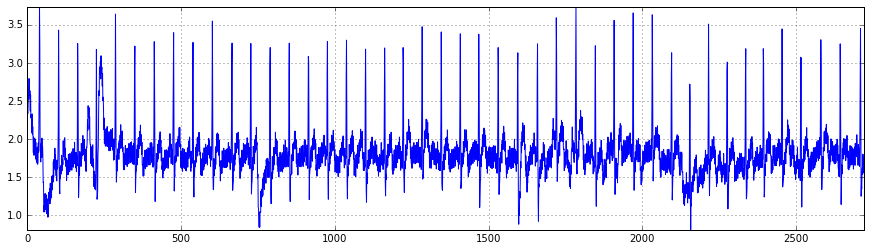

In [461]:
## Load and clean data.
# Todo: refactor to function and call it in __main__

with open("data/pulse5.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_data.append(float(line.rstrip().split(';')[1]))
raw_signal = np.array(raw_data)
# raw_signal = raw_signal / max(raw_signal)

plt.figure(figsize=(15,4))
plt.plot(raw_signal, label="Original signal")
plt.grid(True)
plt.axis("tight")

(0.0, 2721.0, -1.0005723211449673, 1.3262007197024808)

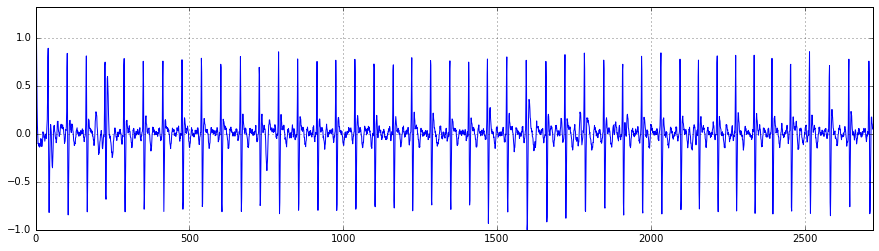

In [462]:
## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, fs, order=1)
# bandpass_signal = bandpass_signal / max(bandpass_signal)

plt.figure(figsize=(15,4))
plt.plot(bandpass_signal, label="Bandpass signal")
plt.grid(True)
plt.axis("tight")

(0.0, 2720.0, -0.89679285764936156, 0.74425122825240242)

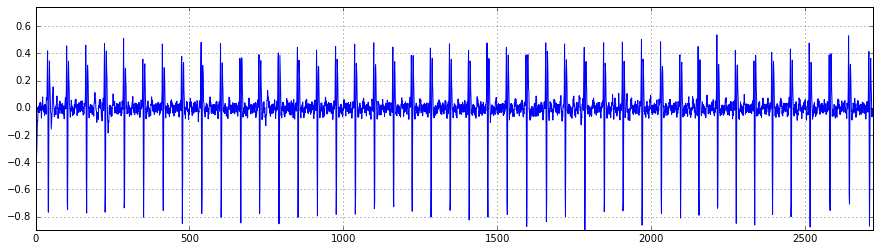

In [463]:
## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)
# Todo: check whether these results should be normalized.
# differentiated_signal = differentiated_signal / max(differentiated_signal)

plt.figure(figsize=(15,4))
plt.plot(differentiated_signal, label="Differentiated signal")
plt.grid(True)
plt.axis("tight")

(0.0, 2720.0, 5.5017964820888364e-10, 0.80423742953090804)

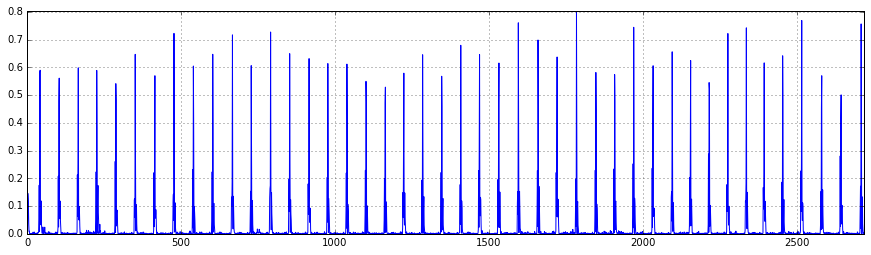

In [464]:
## Squaring - signal is squared point by point.
# Todo: use numpy array vectorized operation to do this squaring.
squared_signal = np.power(differentiated_signal, 2)
# Todo: check whether normalization should be here.
# Todo: normalize using numpy function.
# squared_signal = squared_signal / max(squared_signal)

plt.figure(figsize=(15,4))
plt.plot(squared_signal, label="Squared signal")
plt.grid(True)
plt.axis("tight")

(0.0, 2731.0, 0.00022212446468415338, 0.1577128044911589)

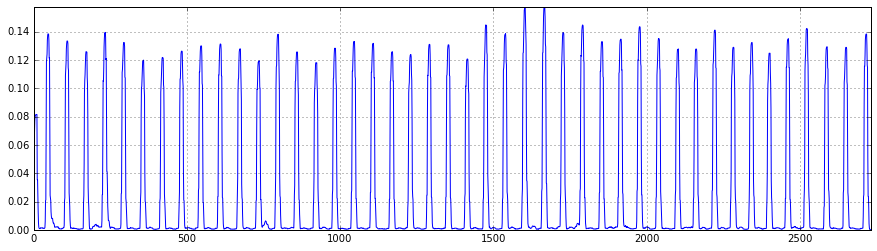

In [465]:
## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
# Todo: check window length
# Todo: dynamic window length based on frequency - first check if freq can be dynamic or can be bigger or smaller
N = 12
# Todo: sprawdzic czy te parametry convolve sa poprawne.
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)
# Todo: check whether result should be normalized.
# integrated_signal = integrated_signal / max(integrated_signal) 

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal")
plt.grid(True)
plt.axis("tight")

(0.0, 2731.0, 0.0, 0.1577128044911589)

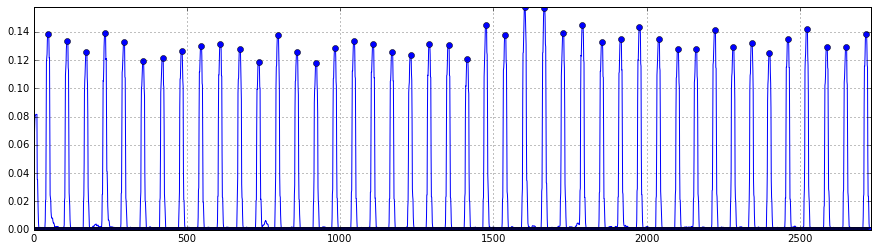

In [466]:
## Fiducial mark - peak detection.
# Todo: investigate usage of find_peaks_cwt
# Todo: refactor fiducial_mark to nparray
# Todo: tune peak detection np.arange(10, 15)
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)
for peak_index in peaks_indices:
#     fiducial_mark = np.append(fiducial_mark, [peak_index, integrated_signal[peak_index]])
    #TODO: CZY TUTAJ POWINIEN BYC PODAWANE VALUE Z INTEGRATED SIGNAL CZY MOZE Z ORYGINALNEGO CZY OBOJETNE?
    fiducial_mark.append((peak_index, integrated_signal[peak_index]))

fiducial_mark_indication = [0] * len(integrated_signal)
for peak in fiducial_mark:
    fiducial_mark_indication[peak[0]] = peak[1]

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal")
plt.plot(fiducial_mark_indication, 'bo')
plt.grid(True)
plt.axis("tight")

### Control final values for 'pulse4.csv':

- noise - peak: 0.162209, npki: 0.020276, threshold1: 1.000000
- pulse - peak: 0.175415, spki: 0.021927, threshold1: 0.015207
- pulse - peak: 0.185014, spki: 0.042313, threshold1: 0.020689
- pulse - peak: 0.167958, spki: 0.058018, threshold1: 0.025785
- pulse - peak: 0.167736, spki: 0.071733, threshold1: 0.029712
- pulse - peak: 0.179816, spki: 0.085244, threshold1: 0.033140

### To do: chart showing peak value against threshold value and marking (red or green/blue) for qrs or noise peak. All on one chart.

In [470]:
## Thresholding detect peaks.
# Todo: refactor for for peak_index, peak_index in fiducial_mark
for peak in fiducial_mark:
        #TODO: CZY TUTAJ POWINIEN BYC PODAWANE VALUE Z INTEGRATED SIGNAL CZY MOZE Z ORYGINALNEGO CZY OBOJETNE?
    if peak[1] > threshold_1:
        qrs_peak.append(peak[0])
        spki = 0.125 * peak[1] + 0.875 * spki
        print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak[1], spki, threshold_1)
        
        ## Todo: refactor threshold_1_vals to ndarray
        spki_vals.append(spki)
        npki_vals.append(npki)
        threshold_1_vals.append(threshold_1)
        threshold_2_vals.append(threshold_2)
    else:
        noise_peak.append(peak[0])
        npki = 0.125 * peak[1] + 0.875 * npki
        print "noise - peak: %f, npki: %f, threshold1: %f" % (peak[1], npki, threshold_1)
        
        ## Todo: refactor threshold_1_vals to ndarray
        npki_vals.append(npki)
        spki_vals.append(spki)
        threshold_1_vals.append(threshold_1)
        threshold_2_vals.append(threshold_2)
    
    peak_vals.append(peak[1])
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

print len(peak_vals)
print len(threshold_1_vals)
print spki_vals
print npki_vals

pulse - peak: 0.138432, spki: 0.134240, threshold1: 0.033410
pulse - peak: 0.133466, spki: 0.134143, threshold1: 0.033560
pulse - peak: 0.125866, spki: 0.133109, threshold1: 0.033536
pulse - peak: 0.139050, spki: 0.133851, threshold1: 0.033277
pulse - peak: 0.132406, spki: 0.133671, threshold1: 0.033463
pulse - peak: 0.119472, spki: 0.131896, threshold1: 0.033418
pulse - peak: 0.121729, spki: 0.130625, threshold1: 0.032974
pulse - peak: 0.126296, spki: 0.130084, threshold1: 0.032656
pulse - peak: 0.129938, spki: 0.130066, threshold1: 0.032521
pulse - peak: 0.131315, spki: 0.130222, threshold1: 0.032516
pulse - peak: 0.127659, spki: 0.129902, threshold1: 0.032555
pulse - peak: 0.118909, spki: 0.128527, threshold1: 0.032475
pulse - peak: 0.137988, spki: 0.129710, threshold1: 0.032132
pulse - peak: 0.125722, spki: 0.129212, threshold1: 0.032428
pulse - peak: 0.118033, spki: 0.127814, threshold1: 0.032303
pulse - peak: 0.128351, spki: 0.127881, threshold1: 0.031954
pulse - peak: 0.133060, 

(0.0, 43.0, 0.0, 0.13610387387520917)

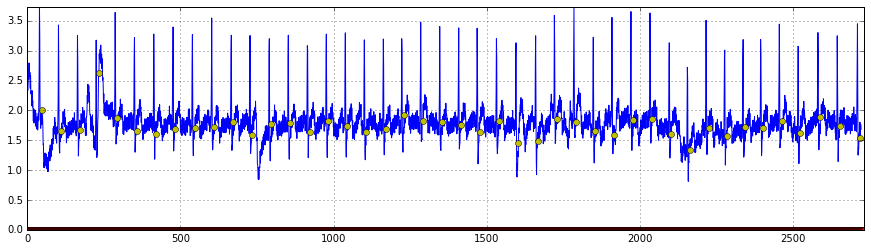

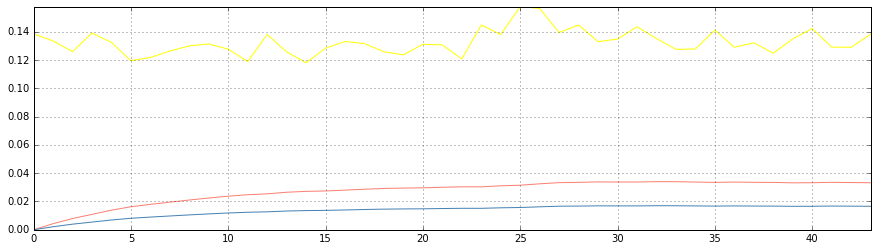

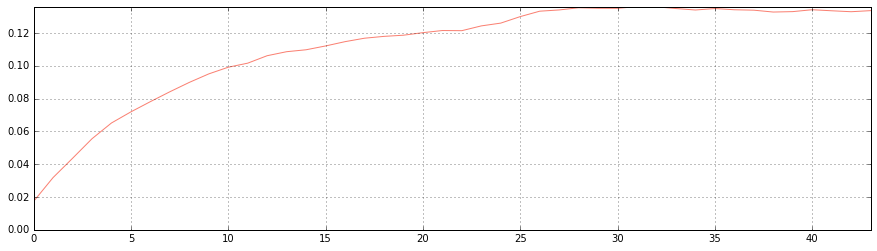

In [468]:
qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[peak] = raw_signal[peak]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]
    
plt.figure(figsize=(15,4))
plt.plot(raw_signal, label="Integrated signal")
plt.plot(qrs_peak_indication, 'yo')
plt.plot(noise_peak_indication, 'ro')
plt.grid(True)
plt.axis("tight")

plt.figure(figsize=(15,4))
plt.plot(threshold_1_vals, color="salmon", label='Threshold 1')
plt.plot(threshold_2_vals, color="steelblue", label='Threshold 2')
plt.plot(peak_vals, color="yellow", label='Peak')
plt.grid(True)
plt.axis('tight')

plt.figure(figsize=(15,4))
plt.plot(spki_vals, color="salmon", label='Spki')
plt.plot(npki_vals, color="steelblue", label='Npki')
plt.grid(True)
plt.axis('tight')


(0.0, 2731.0, 0.0, 3.739002943)

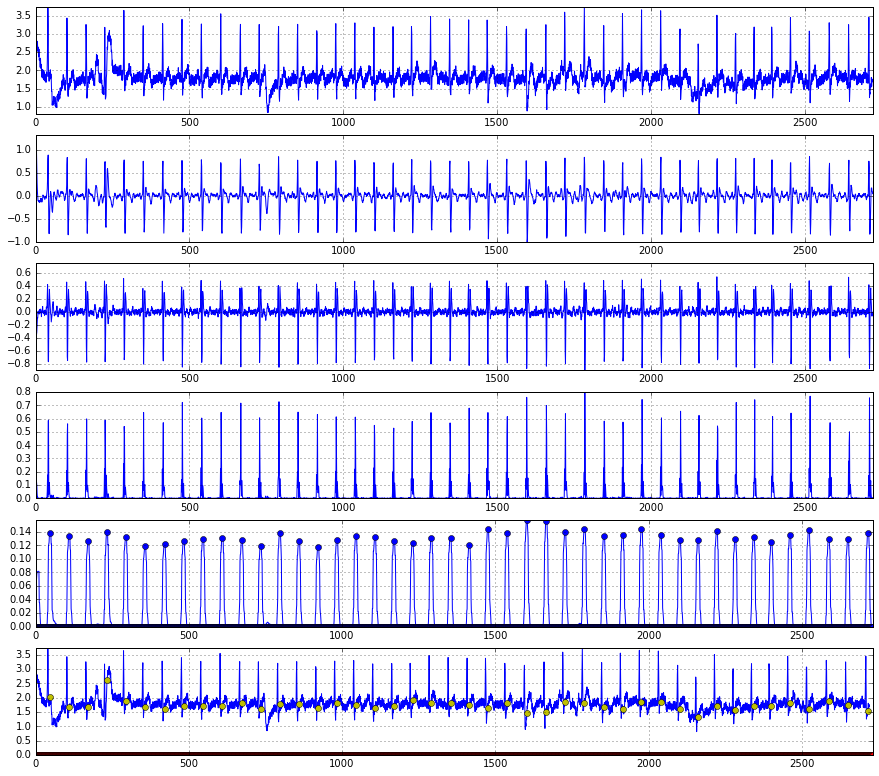

In [469]:
## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak in fiducial_mark:
    fiducial_mark_indication[peak[0]] = peak[1]
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal")
plt.plot(fiducial_mark_indication, 'bo')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[peak] = raw_signal[peak]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal")
plt.plot(qrs_peak_indication, 'yo')
plt.plot(noise_peak_indication, 'ro')
plt.grid(True)
plt.axis("tight")
